## Домашнее задание. Временные ряды 2

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" 
2. Оцените ошибку модели из п.1 
3. Сделайте вывод о том, как изменилась ошибка модели по значениям h

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os

In [7]:
Path_Energy = 'my_PJME_MW.csv'
energy_data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

energy_data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


**Сглаживание**

In [18]:
energy_data_d = energy_data.resample('D').mean()

In [19]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [20]:
energy_ar = energy_data_d['PJME_MW'].values
energy_s = pd.DataFrame(data = energy_data_d[['PJME_MW']])

In [21]:
N2 = 24*7

Text(0.5, 1.0, 'PJME_MW')

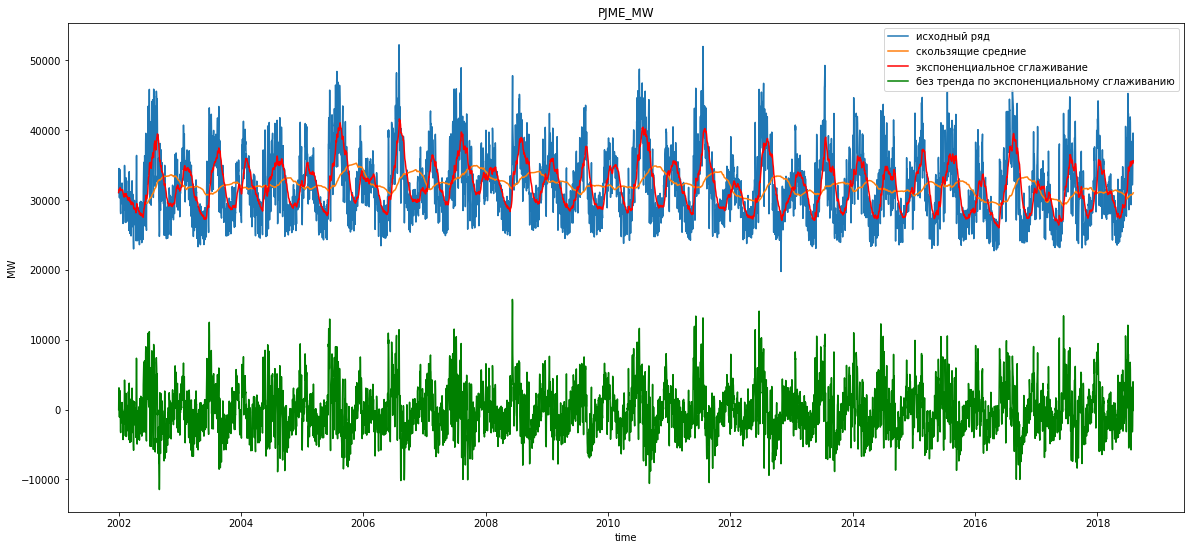

In [22]:
energy_ar_exp_1 = exponential_smoothing(energy_data_d['PJME_MW'], 0.05)

plt.figure(figsize=(20, 9))
plt.plot(energy_s.index, energy_s['PJME_MW'], label='исходный ряд')
plt.plot(energy_s['PJME_MW'].rolling(window=N2).mean(), label="скользящие средние");

plt.plot(energy_s.index,energy_ar_exp_1, color = 'red', label="экспоненциальное сглаживание");
plt.plot(energy_s.index,energy_s['PJME_MW'] - energy_ar_exp_1, color = 'green', label="без тренда по экспоненциальному сглаживанию");
plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

Text(0.5, 1.0, 'PJME_MW')

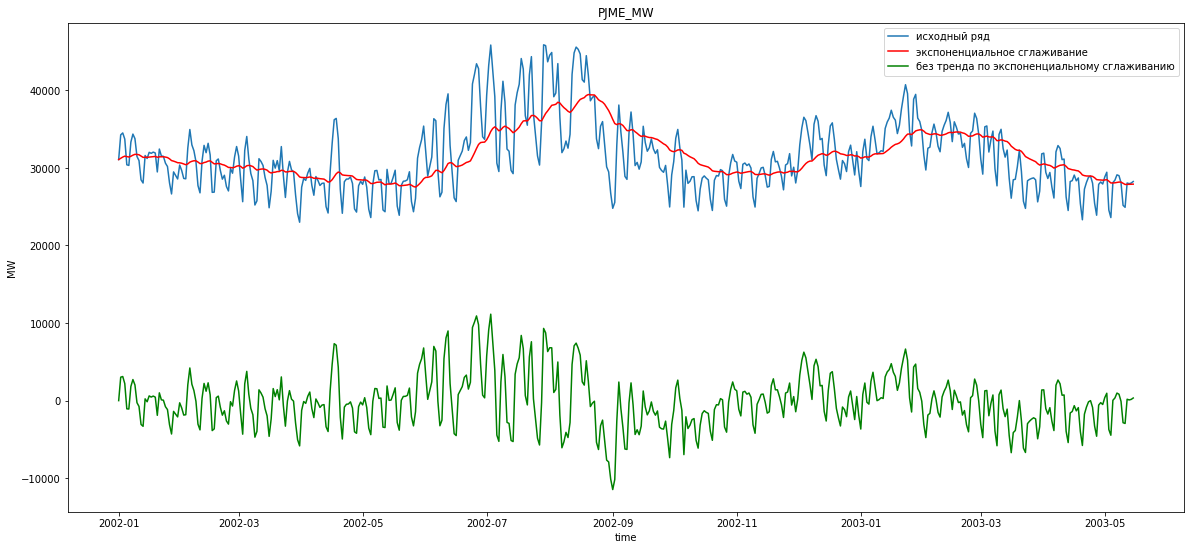

In [23]:
plt.figure(figsize=(20, 9))
plt.plot(energy_s.index[:500], energy_s['PJME_MW'].values[:500], label='исходный ряд')

plt.plot(energy_s.index[:500],energy_ar_exp_1[:500], color = 'red', label="экспоненциальное сглаживание");
plt.plot(energy_s.index[:500],energy_s['PJME_MW'].values[:500] - energy_ar_exp_1[:500], color = 'green', label="без тренда по экспоненциальному сглаживанию");
plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

**Feature engineering**

In [27]:
energy_ar_exp_1 = pd.DataFrame(data = energy_ar_exp_1, index = energy_s.index)

In [28]:
df= pd.DataFrame(energy_ar_exp_1)

df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']= 0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']= 0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0
df['diff1'].iloc[1:] = df.iloc[:-1,0]-df.iloc[1:,0]


df.head()

,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.0
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,31082.329532,31085.510334,31093.462341,0.0
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,31085.540077,31095.046546,31118.256077,0.0
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,31089.874554,31107.764782,31150.314611,0.0
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,31093.608754,31118.430677,31175.353012,0.0


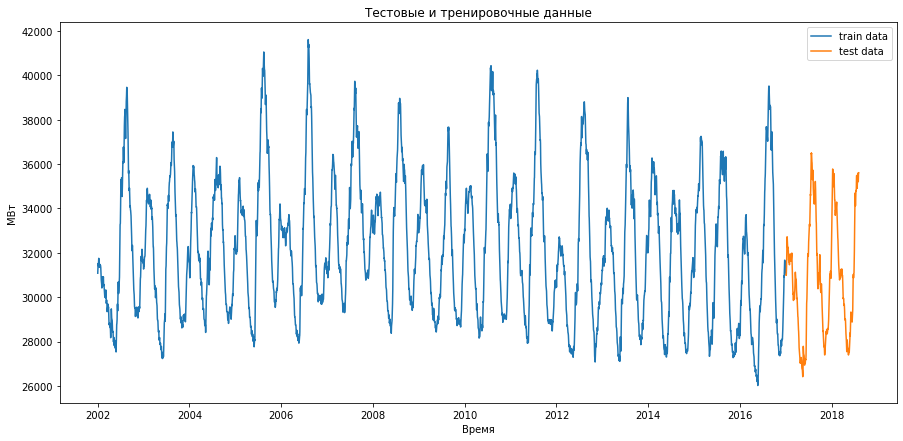

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

# сделаем примеры и модель 
def split_data_energy( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train_en, test_en = split_data_energy( df, '2017-01-01')

X_train_en = train_en.iloc[:-1,:]
y_train_en = train_en[df.columns[0]].values[1:]
X_test_en = test_en.iloc[:-1,:]
y_test_en = test_en[df.columns[0]].values[1:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('МВт')
plt.plot(train_b.index.get_level_values('Date'),train_en[df.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_en[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

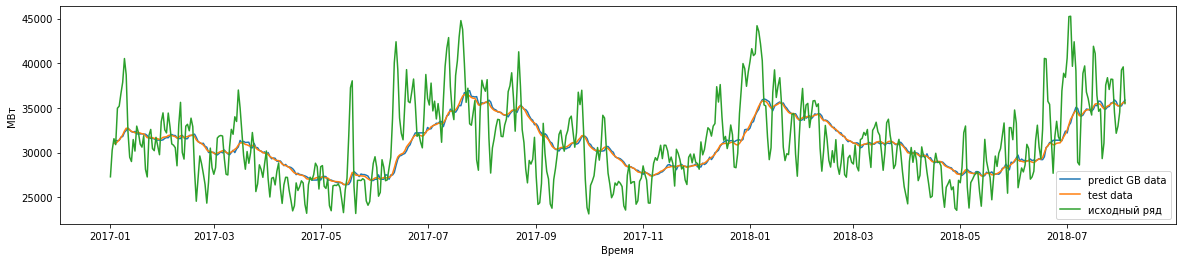

ошибка градиентного бустинга :   0.49971881056577727 %


In [37]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_en, y_train_en ) 
X_test_pred_gb = model_gb.predict(X_test_en)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('МВт')
plt.plot(test_en.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_en.index[1:],y_test_b, label='test data')
plt.plot(energy_s.loc['2017-01-01':].index, energy_s.loc['2017-01-01':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

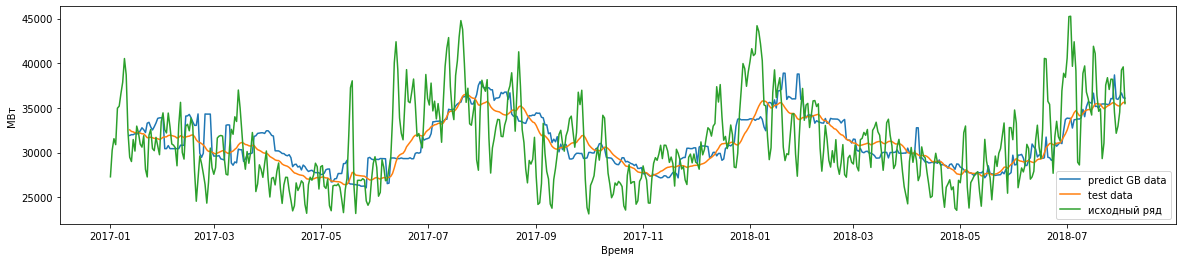

ошибка градиентного бустинга :   3.3120767286356587 %


In [53]:
h=10
X_train_en = train_en.iloc[:-h,:]
y_train_en = train_en[df.columns[0]].values[h:]
X_test_en = test_en.iloc[:-h,:]
y_test_en = test_en[df.columns[0]].values[h:]

model_gb.fit( X_train_en, y_train_en ) 
X_test_pred_gb = model_gb.predict(X_test_en)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('МВт')
plt.plot(test_en.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_en.index[h:],y_test_en, label='test data')
plt.plot(energy_s.loc['2017-01-01':].index, energy_s.loc['2017-01-01':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_en, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

In [47]:
err_list = []

for h in range(1, 11):
    X_train_en = train_en.iloc[:-h,:]
    y_train_en = train_en[df.columns[0]].values[h:]
    X_test_en = test_en.iloc[:-h,:]
    y_test_en = test_en[df.columns[0]].values[h:]
    
    model_gb.fit( X_train_en, y_train_en ) 
    X_test_pred_gb = model_gb.predict(X_test_en)

    er_g = mean_absolute_percentage_error(y_true=y_test_en, y_pred=X_test_pred_gb)
    err_list.append(er_g)

    print(f'Глубина прогноза {h} ошибка градиентного бустинга : {er_g}%')

Глубина прогноза 1 ошибка градиентного бустинга : 0.49971881056577727%
Глубина прогноза 2 ошибка градиентного бустинга : 0.9871969054535175%
Глубина прогноза 3 ошибка градиентного бустинга : 1.4724548510284532%
Глубина прогноза 4 ошибка градиентного бустинга : 1.8949770371958947%
Глубина прогноза 5 ошибка градиентного бустинга : 2.3224615221950304%
Глубина прогноза 6 ошибка градиентного бустинга : 2.4781426225761334%
Глубина прогноза 7 ошибка градиентного бустинга : 2.7219279210992986%
Глубина прогноза 8 ошибка градиентного бустинга : 3.0792077046137893%
Глубина прогноза 9 ошибка градиентного бустинга : 3.3063246774503128%
Глубина прогноза 10 ошибка градиентного бустинга : 3.3120767286356587%


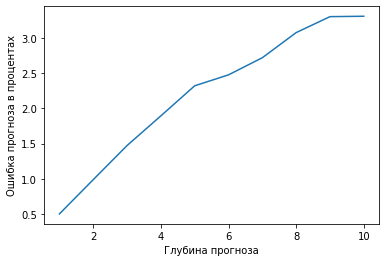

In [52]:
x = list(range(1, 11))

plt.figure()
plt.xlabel('Глубина прогноза')
plt.ylabel('Ошибка прогноза в процентах')
plt.plot(x, err_list)

С увеличением глубины прогноза ошибка возрастает, имея при этом в начале линейный участок (до x=3). Учитывая, что глубина окна равна всего 3, неудевительно, что не удается точно предсказывать на 10 значений вперед.

4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):<br>
    **a)** Изменение температуры за окном<br>
    Думаю, этот ряд точно будет иметь сезонность с годовым циклом (очевидно) и, возможно, неярко выраженный тренд в сторону потепления, учитывая так часто встречающиеся новости о глобальном потеплении. Невыраженный, потому что, процессы, влияющие на температуру глобально происходят достаточно медленно по меркам человека.<br>
    **б)** Количество денег, которые тратят покупатели в интернет магазине.<br>
    Если говорить о тратах одного человека, т.е. рассматривать, сколько денег оставляет один человек в этом магазине, делая покупку, думаю это будет стационарный график, мало зависящий от сезонов, а тренд, вероятно, будет во многом определяться экономическими процессами в стране, такие как инфляция и курс рубля. Если же рассматривать, сколько в совокупности люди тратят в этом магазине, то тут уже должна появиться сезонность с годовыми, месячными, недельными и даже дневными циклами (наверняка, люди больше заказывают товаров в нерабочее для себя время, и в конце месяцев, когда многие получают зарплату), тренд, кроме политики руководства, которая может быть совершенно разной, но в целом должна быть направлена на увеличение продаж, также будет определяться трендом в индустрии в целом, в которой работает магазин. Думаю, динамика продаж у одежды, детских товаров и, например, гаджетов будет заметно различаться.<br>
    **в)** Вес растущего котенка.
    Здесь, на мой взгляд, должен быть виден тренд на увеличение (котенок растет - вес увеличивается), сезонность я бы не стал рассматривать, хотя не знаком досконально с поведением кошек. Но, предполагаю, что, учитывая то, что кошки живут дома в примерно одинаковых условиях в течениях года, им нет необходимости набирать вес к зиме, как это делают другие дикие животные.<br>
    **г)** Прирост объема деревьев в лесу от времени<br>
    Здесь должна быть сезонность с годовым циклом, если я правильно понимаю, деревья скорее размножаются в летнее время. И, учитывая массовую вырубку лесов, ожидаю увидеть на графике негативный тренд в целом по миру.
    